In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import japanize_matplotlib


In [36]:
# グラフを描画する
def plot(
    df,
    heads=[],
    title=None,
    xlabel=None,
    ylabel=None,
    figsize=(10, 3),
    xlim=(0, 0),
    ylim=(0, 0),
    interval_ms=0,
    threshold=0,
    grid=True,
    output_sampling_rate=False
):
    fig = plt.figure(figsize=figsize)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if grid:
        plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

    if xlim[0] < xlim[1]:
        plt.xlim(xlim[0], xlim[1])
    if ylim[0] < ylim[1]:
        plt.ylim(ylim[0], ylim[1])

    for head in heads:
        plt.plot(df[head[0]], df[head[1]], label=head[1])

    # サンプリング周波数
    t = (df['time'].iloc[-1] - df['time'].iloc[0])
    sampling_rate = df.shape[0] / t
    del t

    if output_sampling_rate:
        print(f'サンプリング周波数: {sampling_rate} Hz')

    variance_data = {"time": [], "variance": []}
    if threshold > 0 and interval_ms > 0:
        interval = math.floor(sampling_rate * interval_ms / 1000)

        for i in range(0, df.shape[0], interval):
            df_cut = df.iloc[i:i + interval]
            variance = df_cut["norm"].var()
            start_time = df_cut['time'].iloc[0]
            end_time = df_cut['time'].iloc[-1]

            variance_data["time"].append((start_time+end_time)/2)
            variance_data["variance"].append(variance)

            if variance > threshold:
                plt.axvspan(
                    start_time,
                    end_time,
                    color='gray',
                    alpha=0.2
                )
        plt.plot(variance_data["time"], variance_data["variance"])

    plt.legend()

    plt.show()


# 加速度から傾きを計算する
def tilt_from_acc(df_acc):
    tilt_angles = []  # 傾きを格納するリスト

    # df_acc を for で回す
    for d in df_acc.itertuples(index=False):
        time = d.time
        x = d.x
        y = d.y
        z = d.z

        gravity = math.sqrt(x ** 2 + y ** 2 + z ** 2)

        # 重力方向となす角度
        tilt_angle_x = math.acos(x / gravity)
        tilt_angle_y = math.acos(y / gravity)
        tilt_angle_z = math.acos(z / gravity)

        tilt_angles.append((time, tilt_angle_x, tilt_angle_y, tilt_angle_z))

    df_tilt = pd.DataFrame(
        tilt_angles,
        columns=["time", "roll", "yaw", "pitch"]
    )
    df_tilt["roll"] = df_tilt["roll"] - math.pi / 2
    df_tilt["yaw"] = df_tilt["yaw"] - math.pi / 2

    return df_tilt


# dataframe を結合する
def concat_by_time(*args_df):
    concated_df = args_df[0].copy()
    for i in range(1, len(args_df)):
        concated_df = pd.merge_asof(
            concated_df, args_df[i], on='time', direction='nearest')

    concated_df = concated_df.sort_values('time')
    concated_df = concated_df.dropna()

    return concated_df


# 角速度と傾きから端末姿勢を推定する
def posture_from_gyro_and_tilt(df_gyro, df_acc, df_tilt, static_threshold=1):
    # カラムラベルを変更
    df_gyro = df_gyro.rename(
        columns={'x': 'gyro_x', 'y': 'gyro_y', 'z': 'gyro_z'}
    )
    df_acc = df_acc.rename(columns={'x': 'acc_x', 'y': 'acc_y', 'z': 'acc_z'})

    # 時間を基準にして結合
    df_concated = concat_by_time(df_gyro, df_acc, df_tilt)
    del df_gyro, df_acc, df_tilt

    # サンプリング周波数
    t = (df_concated['time'].iloc[-1] - df_concated['time'].iloc[0])
    sampling_rate = df_concated.shape[0] / t
    del t

    # 区間の長さ
    time_ms = 200
    interval = math.floor(sampling_rate * time_ms / 1000)

    # 初期化
    posture = []

    # df_concated を 200ms ごとに切り出す
    df_prev_part = df_concated.iloc[0:interval]
    for i in range(0, df_concated.shape[0], interval):
        df_part = df_concated.iloc[i:i + interval]

        # norm の分散
        variance = df_part["norm"].var()

        if variance < static_threshold:
            posture.append([
                df_part["time"].mean(),
                df_part["pitch"].mean(),
                df_part["roll"].mean(),
                df_part["yaw"].mean(),
                df_part["acc_x"].mean(),
                df_part["acc_y"].mean(),
                df_part["acc_z"].mean(),
                df_part["norm"].mean(),
            ])
        else:
            prev_posture = posture[-1] \
                if len(posture) > 0 \
                else [0, 0, 0, 0, 0, 0, 0, 0, 0]
            gyro_x = df_prev_part["gyro_x"].mean() * time_ms / 1000
            gyro_y = df_prev_part["gyro_y"].mean() * time_ms / 1000
            gyro_z = df_prev_part["gyro_z"].mean() * time_ms / 1000

            posture.append([
                df_part["time"].mean(),
                prev_posture[1] + gyro_x,
                prev_posture[2] + gyro_y,
                prev_posture[3] + gyro_z,
                df_part["acc_x"].mean(),
                df_part["acc_y"].mean(),
                df_part["acc_z"].mean(),
                df_part["norm"].mean(),
            ])

        df_prev_part = df_part

    df_posture = pd.DataFrame({
        "time": [p[0] for p in posture],
        "pitch": [p[1] for p in posture],
        "roll": [p[2] for p in posture],
        "yaw": [p[3] for p in posture],
        "acc_x": [p[4] for p in posture],
        "acc_y": [p[5] for p in posture],
        "acc_z": [p[6] for p in posture],
        "norm": [p[7] for p in posture],
    })
    return df_posture


# ベクトルを回転させる
def rotate(np_vec, pitch, roll, yaw):
    r_x = np.array([
        [1, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch)],
        [0, np.sin(pitch), np.cos(pitch)]
    ])
    r_y = np.array([
        [np.cos(roll), 0, np.sin(roll)],
        [0, 1, 0],
        [-np.sin(roll), 0, np.cos(roll)]
    ])
    r_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    np_vec = np.dot(r_x, np_vec)
    np_vec = np.dot(r_y, np_vec)
    np_vec = np.dot(r_z, np_vec)

    return np_vec


# 端末座標系を端末の向きに合わせて回転させる
def rotate_device_coordinate_system(df_posture):
    rotated_acc = []
    for data in df_posture.itertuples(index=False):
        # 元のベクトル
        x = data.acc_x
        y = data.acc_y
        z = data.acc_z
        np_vec = np.array([x, y, z])

        # 回転後のベクトル
        vec_dash = rotate(
            np_vec,
            data.pitch,
            data.roll,
            data.yaw,
        )

        # 回転後の値を格納
        rotated_acc.append([
            data.time,
            vec_dash[0],
            vec_dash[1],
            vec_dash[2],
        ])

    df_rotated_acc = pd.DataFrame(rotated_acc, columns=['time', 'x', 'y', 'z'])
    return df_rotated_acc


In [37]:
folder_name = "run_kururu"
file_path = f"./logs/{folder_name}/"
df_acc = pd.read_csv(
    f"{file_path}Accelerometer.csv",
    header=0,
    names=("time", "x", "y", "z")
)

df_gyro = pd.read_csv(
    f"{file_path}Gyroscope.csv",
    header=0,
    names=("time", "x", "y", "z")
)


In [38]:
# 加速度のノルムを計算
df_acc['norm'] = np.linalg.norm(df_acc[['x', 'y', 'z']], axis=1)

# 角速度から傾きを計算
df_gyro['rotate_x'] = np.cumsum(df_gyro['x']) / 400
df_gyro['rotate_y'] = np.cumsum(df_gyro['y']) / 400
df_gyro['rotate_z'] = np.cumsum(df_gyro['z']) / 400


In [39]:
# 加速度から傾きを計算
df_tilt = tilt_from_acc(df_acc)

# 姿勢を推定
df_posture = posture_from_gyro_and_tilt(df_gyro, df_acc, df_tilt, static_threshold=0)
df_posture.to_csv(f"{file_path}posture.csv", index=True)

# 世界座標系に変換
df_rotated_acc = rotate_device_coordinate_system(df_posture)


In [40]:
# df_posture をコピー
posture = df_posture.copy()

# サンプリング周波数
t = (df_rotated_acc['time'].iloc[-1] - df_rotated_acc['time'].iloc[0])

# acc_y を積分
posture['y'] = np.cumsum(df_rotated_acc['y']) / t * 10

# posture から　余分なカラムを削除
posture = posture.drop(columns=['acc_x', 'acc_y', 'acc_z', 'norm'])

# rad を deg に変換
posture['pitch'] = posture['pitch'] * 180 / math.pi
posture['roll'] = posture['roll'] * 180 / math.pi
posture['yaw'] = posture['yaw'] * 180 / math.pi

# 端末姿勢をcsv に出力
posture.to_csv(f"./{folder_name}.csv", index=False, header=False)

In [41]:
# df_rotated_acc[z] を積分
df_rotated_acc['pos_x'] = np.cumsum(df_rotated_acc['x']) / t * 10
df_rotated_acc['pos_y'] = np.cumsum(df_rotated_acc['y']) / t * 10
df_rotated_acc['pos_z'] = np.cumsum(df_rotated_acc['z'] - 9.8) / t * 10


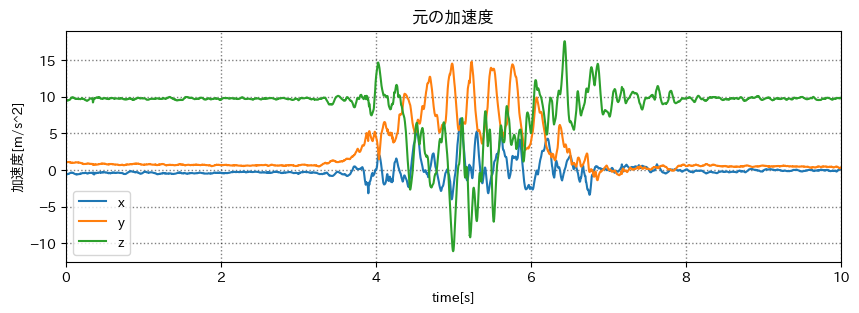

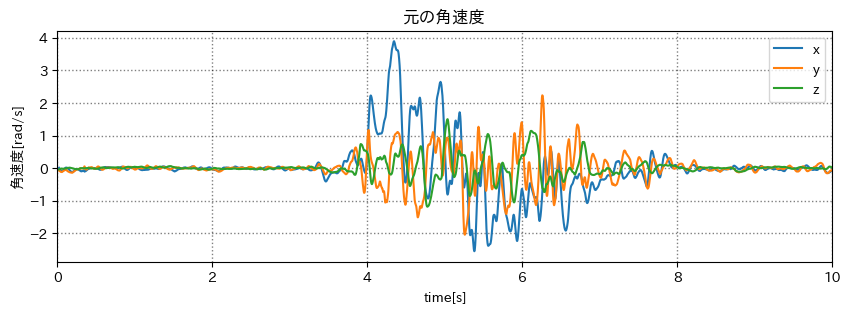

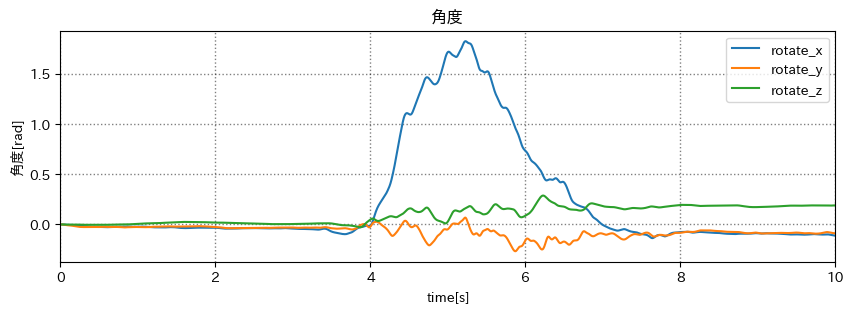

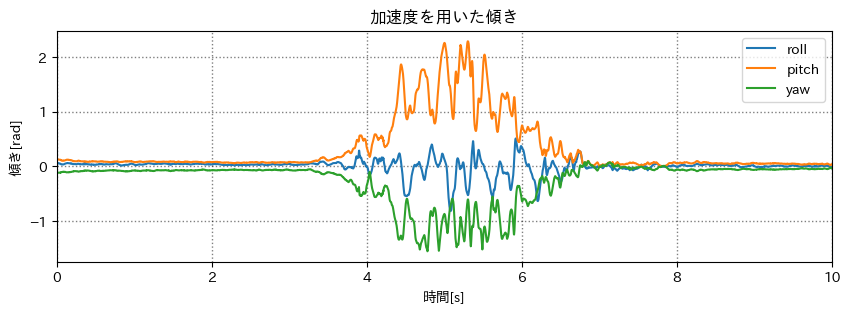

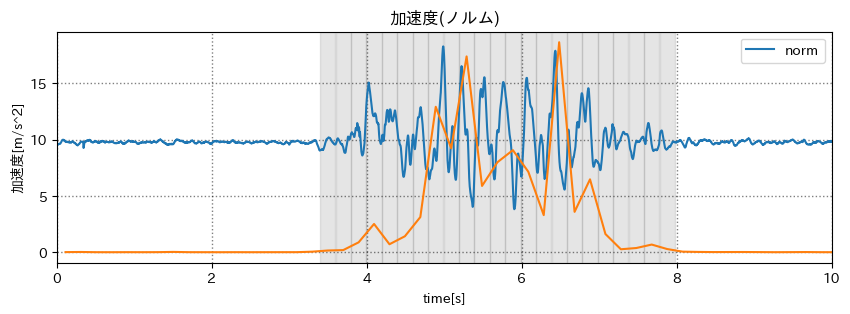

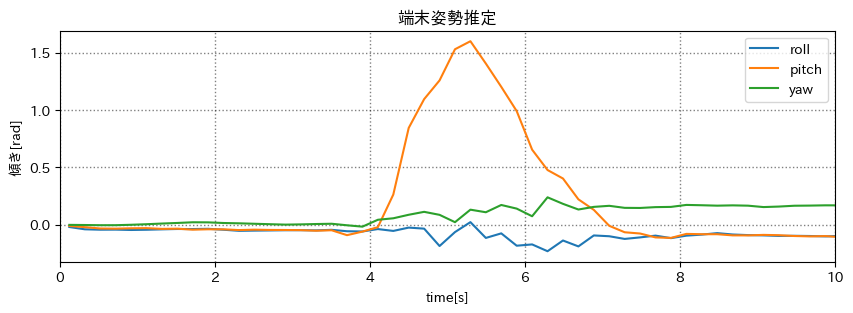

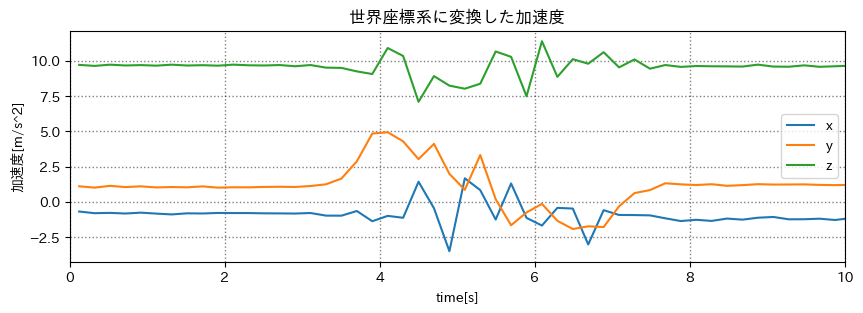

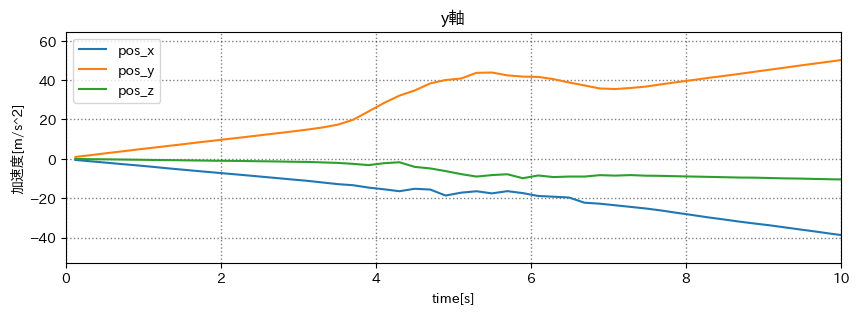

In [42]:
# グラフの設定
xlim = (0, 10)

# 加速度のグラフ
plot(
    df_acc,
    heads=[
        ("time", "x"),
        ("time", "y"),
        ("time", "z"),
    ],
    title="元の加速度",
    xlabel="time[s]",
    ylabel="加速度[m/s^2]",
    xlim=xlim,
    grid=True,
)

# 角速度のグラフ
plot(
    df_gyro,
    heads=[
        ('time', 'x'),
        ('time', 'y'),
        ('time', 'z'),
    ],
    xlim=xlim,
    title="元の角速度",
    xlabel="time[s]",
    ylabel="角速度[rad/s]",
)

# 角度のグラフ
plot(
    df_gyro,
    heads=[
        ('time', 'rotate_x'),
        ('time', 'rotate_y'),
        ('time', 'rotate_z'),
    ],
    xlim=xlim,
    title="角度",
    xlabel="time[s]",
    ylabel="角度[rad]",
)

# 加速度を用いた傾きのグラフ
plot(
    df_tilt,
    heads=[
        ["time", "roll"],
        ["time", "pitch"],
        ["time", "yaw"],
    ],
    title="加速度を用いた傾き",
    xlabel="時間[s]",
    ylabel="傾き[rad]",
    xlim=xlim,
    grid=True,
)

# 加速度のノルムのグラフ
plot(
    df_acc,
    heads=[
        ("time", "norm"),
    ],
    title="加速度(ノルム)",
    xlabel="time[s]",
    ylabel="加速度[m/s^2]",
    xlim=xlim,
    interval_ms=200,
    threshold=0.1,
    grid=True,
)

# 端末姿勢のグラフ
plot(
    df_posture,
    heads=[
        ("time", "roll"),
        ("time", "pitch"),
        ("time", "yaw"),
    ],
    title="端末姿勢推定",
    xlabel="time[s]",
    ylabel="傾き[rad]",
    xlim=xlim,
    grid=True
)

# 世界座標系に変換した加速度のグラフ
plot(
    df_rotated_acc,
    heads=[
        ("time", "x"),
        ("time", "y"),
        ("time", "z"),
    ],
    title="世界座標系に変換した加速度",
    xlabel="time[s]",
    ylabel="加速度[m/s^2]",
    xlim=xlim,
    grid=True
)

# y 方向のグラフ
plot(
    df_rotated_acc,
    heads=[
        ("time", "pos_x"),
        ("time", "pos_y"),
        ("time", "pos_z"),
    ],
    title="y軸",
    xlabel="time[s]",
    ylabel="加速度[m/s^2]",
    xlim=xlim,
    grid=True
)
